# PHYS 305 - Homework #3 - Jake Larimer

### 1. (a)
Solve the Sun–Earth–Jupiter system system varying Jupiter’s mass MJ and
orbital semi-major axis RJ as follows: (i) MJ = 0.01, RJ = 3.0, (ii) MJ = 0.02, RJ = 2.1,
(iii) MJ = 0.03, RJ = 2.0. Take ϵ = 0 and run to t = 1000. In each case, plot Earth’s orbital
eccentricity e as a function of time and determine the maximum eccentricity emax reached
over the course of the calculation.

Command-line parameters:
{'N': 3,
 'dt': 0.01,
 'dt_dia': 10.0,
 'eps': 1e-06,
 'mj': 0.01,
 'rj': 3.0,
 'seed': 42,
 't_end': 1000.0,
 'v0': 0.25}
Initial E = -0.0016681761039502893
t = 0.0 dE = 0.0
semimajor axis = 0.9999999999999998  eccentricity = 1.0000444493033002e-06
t = 9.999999999999831 dE = 9.36293143710687e-14
t = 20.000000000000327 dE = -5.29327016246528e-14
t = 30.00000000000189 dE = 8.759919872813882e-15
t = 40.00000000000061 dE = 1.1348452559623023e-13
t = 49.99999999999862 dE = 2.4240158491561914e-14
t = 59.99999999999663 dE = 7.056117842796361e-14
t = 69.9999999999989 dE = -4.834500855199764e-14
t = 80.00000000000402 dE = 3.27830210894442e-14
t = 90.00000000000914 dE = 8.407662586973341e-14
t = 100.00000000001425 dE = -1.3969988360562624e-13
t = 110.00000000001937 dE = 2.2818097238086477e-13
t = 120.00000000002449 dE = -3.585825213148208e-14
t = 130.00000000002674 dE = 7.625996188698192e-14
t = 140.00000000001765 dE = -2.2909625585487703e-14
t = 150.00000000000855 dE =

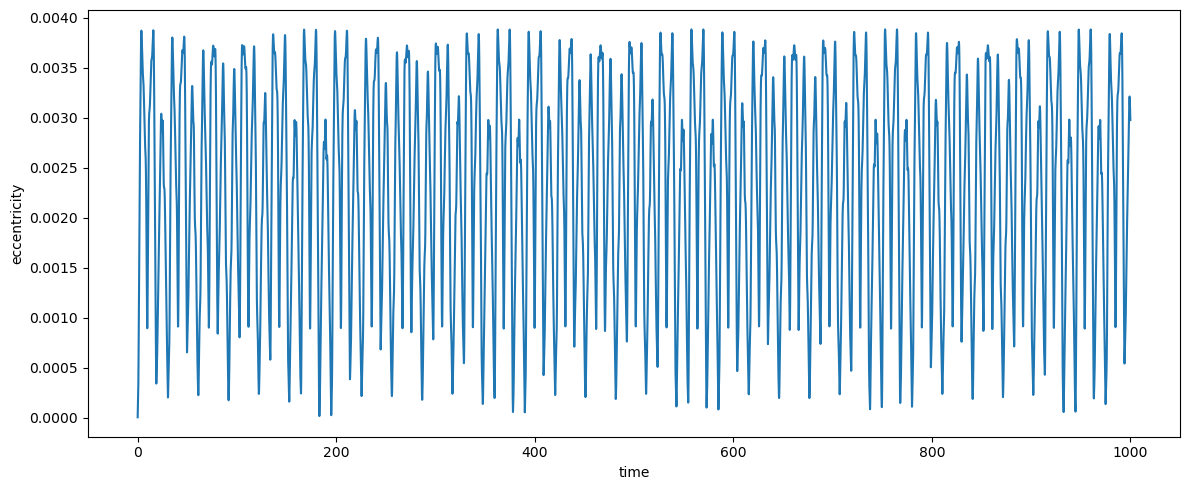

Max Eccentricity : 0.00388237625778685


In [15]:
### (i) ###
### 3body.py, modified ###

import numpy as np
import matplotlib.pyplot as plt
import sys ###

def initialize(n, v0, eps2, mj, rj):
    mass = np.ones(n)/n
    if n == 2:
        pos = np.array([[1.0,0,0],[-1.0,0,0]])
        vel = np.array([[0,v0,0],[0,-v0,0]])
    else:
        # Simple planetary system.
        ms = 1.0
        me = 3.e-6
        re = 1.0
        mass = np.array([ms, me, mj])
        pos = np.array([[0.,0.,0.], [re,0.,0.], [0.,rj,0.]])
        vel = np.array([[0.,0.,0.],
                        [0.,np.sqrt((ms+me)*re/(re**2+eps2)),0.],
                        [-np.sqrt((ms+mj)*rj/(rj**2+eps2)),0.,0.]])

    # Move to the center of mass frame.
    
    m = mass.reshape(n,1)/mass.sum() # mi/mtot
    pos -= (m*pos).sum(axis=0) # xij - sum_i(xij*mi/mtot)
    vel -= (m*vel).sum(axis=0)

    return mass, pos, vel

def potential_energy(mass, pos, eps2):
    pot = 0.0
    for i in range(len(mass)):
        r = pos[i+1:] - pos[i]
        r2 = (r**2).sum(axis=1) + eps2 #axis = 1 sums over columns (dimensions), result of size rows (bodies) j>i
        pot -= mass[i]*(mass[i+1:]/np.sqrt(r2)).sum() #piecewise division due to numpy broadcasting, sum over bodies j>i
    return pot

def kinetic_energy(mass, vel):
    return 0.5*(mass*(vel**2).sum(axis=1)).sum() #sum over dimensions first, then bodies

def energy(mass, pos, vel, eps2):
    T = kinetic_energy(mass, vel)
    U = potential_energy(mass, pos, eps2)
    return T+U

def output(t, E0, mass, pos, vel, eps2):
    E = energy(mass, pos, vel, eps2)
    print('t =', t, 'dE =', E-E0)

def acceleration(mass, pos, eps2):
    n = len(mass)
    acc = np.zeros((n,3)) # acc modified in place
    for i in range(n):
        r = pos - pos[i,:] #del x,y,z to all other bodies, including itself
        r2  = (r**2).sum(axis=1) + eps2 #summing over dimensions, size of bodies
        acc[i] = (r*(mass/(np.power(r2,1.5))).reshape(n,1)).sum(axis=0) #reshape to multiply with corresponding body pair, sum over body pairs
    return acc

def step(t, mass, pos, vel, eps2, dt):

    # Second-order predictor-corrector.

    acc = acceleration(mass, pos, eps2)
    pos += dt*(vel+0.5*dt*acc)
    anew = acceleration(mass, pos, eps2)
    vel += 0.5*dt*(acc+anew)

    return t+dt,pos,vel

def kdk_step(t, mass, pos, vel, eps2, dt):
    vel += 0.5*acceleration(mass, pos, eps2)*dt
    pos += vel*dt
    vel += 0.5*acceleration(mass, pos, eps2)*dt
    t += dt
    return t, pos, vel

def orbital_elements(m1, m2, x1, x2, v1, v2, eps2):
    M = m1+m2
    x = x2-x1
    v = v2-v1
    r2 = (x**2).sum() + eps2
    v2 = (v**2).sum()
    E = 0.5*v2 - M/np.sqrt(r2)
    a = -0.5*M/E
    h2 = ((np.cross(x,v))**2).sum()
    ecc = (1 + 2*E*h2/M**2)**0.5
    return a, ecc, E, h2**0.5
    
def main(N, seed, eps, dt, t_end, dt_dia, v0, mj, rj):
    # Initial conditions.

    t = 0.0
    mass, pos, vel = initialize(N, v0, eps**2, mj, rj)

    # Initial diagnostics.
    
    E0 = energy(mass, pos, vel, eps**2)
    print('Initial E =', E0)
    output(t, E0, mass, pos, vel, eps**2)
    a,e,Erel,h = orbital_elements(mass[0], mass[1], pos[0], pos[1],
                                  vel[0], vel[1], eps**2)
    print('semimajor axis =', a, ' eccentricity =', e)

    # Run forward to specified time.

    tplot = []
    dEplot = []
    hplot = []
    aplot = []
    eccplot = []

    t_dia = dt_dia

    while t < t_end-0.5*dt:
        t,pos,vel = step(t, mass, pos, vel, eps**2, dt)
        
        E = energy(mass, pos, vel, eps**2)
        a, e, Erel, h = orbital_elements(mass[0], mass[1], pos[0],
                                      pos[1], vel[0], vel[1], eps**2)
        if t >= t_dia-0.5*dt:
            t_dia += dt_dia
            output(t, E0, mass, pos, vel, eps**2)
            if a <= 0.0:
                print('escaped')
                break

        tplot.append(t)
        dEplot.append(E-E0)
        hplot.append(h)
        aplot.append(a)
        eccplot.append(e)

    # Final diagnostics.
    
    output(t, E0, mass, pos, vel, eps**2)

    plt.figure(figsize=(12,5))

    # dont need to plot semimajor    
    #plt.subplot(2,1,1)
    #plt.plot(tplot, aplot)
    #plt.xlabel('time')
    #plt.ylabel('semimajor axis')

    #plt.subplot(2,1,2)
    plt.plot(tplot, eccplot)
    plt.xlabel('time')
    plt.ylabel('eccentricity')

    plt.tight_layout()
    plt.show()

    print(f"Max Eccentricity : {np.max(eccplot)}")

def new_option_parser():
    from optparse import OptionParser
    result = OptionParser()
    result.add_option("-n", 
                      dest="N", type="int", default ="3",
                      help="number of particles [%default]")
    result.add_option("-s", 
                      dest="seed", type="int", default ="42",
                      help="random seed [%default]")
    result.add_option("-e", 
                      dest="eps", type="float", default ="1e-6",
                      help="softening length eps [%default]") # Set to ~0 
    result.add_option("-d", 
                      dest="dt", type="float", default ="0.01",
                      help="time step [%default]")
    result.add_option("-D", 
                      dest="dt_dia", type="float", default ="10.0",
                      help="diagnostic time step [%default]")
    result.add_option("-M", 
                      dest="mj", type="float", default ="0.01",
                      help="Jupiter mass [%default]") # Set to 0.01
    result.add_option("-R", 
                      dest="rj", type="float", default ="3.",
                      help="Jupiter semimajor axis [%default]") # Set to 3.0
    result.add_option("-t", 
                      dest="t_end", type="float", default ="1000.0",
                      help="integration interval [%default]") # Set to 1000
    result.add_option("-v", 
                      dest="v0", type="float", default ="0.25",
                      help="initial 2-body v [%default]")
    return result

if __name__ in ('__main__'):
    sys.argv = sys.argv[:1] # Allows use with Jupyter notebook
    o, arguments  = new_option_parser().parse_args()
    import pprint
    pp = pprint.PrettyPrinter()
    print('Command-line parameters:')
    pp.pprint(o.__dict__)
    main(**o.__dict__)


Command-line parameters:
{'N': 3,
 'dt': 0.01,
 'dt_dia': 10.0,
 'eps': 1e-06,
 'mj': 0.02,
 'rj': 2.1,
 'seed': 42,
 't_end': 1000.0,
 'v0': 0.25}
Initial E = -0.004763430277720129
t = 0.0 dE = 0.0
semimajor axis = 0.9999999999999998  eccentricity = 1.0000444493033002e-06
t = 9.999999999999831 dE = 2.564956060047141e-12
t = 20.000000000000327 dE = -2.165923690400362e-13
t = 30.00000000000189 dE = 1.2671487123472325e-12
t = 40.00000000000061 dE = -2.054398318129813e-13
t = 49.99999999999862 dE = -2.389053364859617e-12
t = 59.99999999999663 dE = 1.7045765840495442e-12
t = 69.9999999999989 dE = -2.8645532126891915e-12
t = 80.00000000000402 dE = 3.25957143221256e-12
t = 90.00000000000914 dE = -2.3306703789138794e-13
t = 100.00000000001425 dE = 1.7827996023900283e-12
t = 110.00000000001937 dE = 2.8813227845314593e-12
t = 120.00000000002449 dE = -4.3892519827060106e-12
t = 130.00000000002674 dE = 4.518895674321399e-12
t = 140.00000000001765 dE = -1.0030842476083102e-11
t = 150.0000000000085

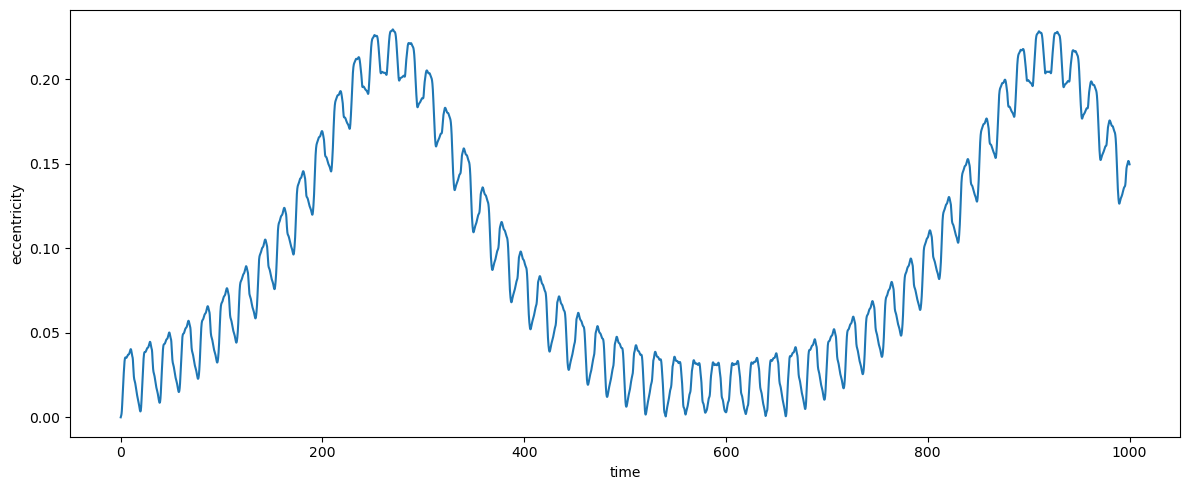

Max Eccentricity : 0.2295721718501714


In [16]:
### (ii) ###
### 3body.py, modified ###

import numpy as np
import matplotlib.pyplot as plt
import sys ###

def initialize(n, v0, eps2, mj, rj):
    mass = np.ones(n)/n
    if n == 2:
        pos = np.array([[1.0,0,0],[-1.0,0,0]])
        vel = np.array([[0,v0,0],[0,-v0,0]])
    else:
        # Simple planetary system.
        ms = 1.0
        me = 3.e-6
        re = 1.0
        mass = np.array([ms, me, mj])
        pos = np.array([[0.,0.,0.], [re,0.,0.], [0.,rj,0.]])
        vel = np.array([[0.,0.,0.],
                        [0.,np.sqrt((ms+me)*re/(re**2+eps2)),0.],
                        [-np.sqrt((ms+mj)*rj/(rj**2+eps2)),0.,0.]])

    # Move to the center of mass frame.
    
    m = mass.reshape(n,1)/mass.sum() # mi/mtot
    pos -= (m*pos).sum(axis=0) # xij - sum_i(xij*mi/mtot)
    vel -= (m*vel).sum(axis=0)

    return mass, pos, vel

def potential_energy(mass, pos, eps2):
    pot = 0.0
    for i in range(len(mass)):
        r = pos[i+1:] - pos[i]
        r2 = (r**2).sum(axis=1) + eps2 #axis = 1 sums over columns (dimensions), result of size rows (bodies) j>i
        pot -= mass[i]*(mass[i+1:]/np.sqrt(r2)).sum() #piecewise division due to numpy broadcasting, sum over bodies j>i
    return pot

def kinetic_energy(mass, vel):
    return 0.5*(mass*(vel**2).sum(axis=1)).sum() #sum over dimensions first, then bodies

def energy(mass, pos, vel, eps2):
    T = kinetic_energy(mass, vel)
    U = potential_energy(mass, pos, eps2)
    return T+U

def output(t, E0, mass, pos, vel, eps2):
    E = energy(mass, pos, vel, eps2)
    print('t =', t, 'dE =', E-E0)

def acceleration(mass, pos, eps2):
    n = len(mass)
    acc = np.zeros((n,3)) # acc modified in place
    for i in range(n):
        r = pos - pos[i,:] #del x,y,z to all other bodies, including itself
        r2  = (r**2).sum(axis=1) + eps2 #summing over dimensions, size of bodies
        acc[i] = (r*(mass/(np.power(r2,1.5))).reshape(n,1)).sum(axis=0) #reshape to multiply with corresponding body pair, sum over body pairs
    return acc

def step(t, mass, pos, vel, eps2, dt):

    # Second-order predictor-corrector.

    acc = acceleration(mass, pos, eps2)
    pos += dt*(vel+0.5*dt*acc)
    anew = acceleration(mass, pos, eps2)
    vel += 0.5*dt*(acc+anew)

    return t+dt,pos,vel

def kdk_step(t, mass, pos, vel, eps2, dt):
    vel += 0.5*acceleration(mass, pos, eps2)*dt
    pos += vel*dt
    vel += 0.5*acceleration(mass, pos, eps2)*dt
    t += dt
    return t, pos, vel

def orbital_elements(m1, m2, x1, x2, v1, v2, eps2):
    M = m1+m2
    x = x2-x1
    v = v2-v1
    r2 = (x**2).sum() + eps2
    v2 = (v**2).sum()
    E = 0.5*v2 - M/np.sqrt(r2)
    a = -0.5*M/E
    h2 = ((np.cross(x,v))**2).sum()
    ecc = (1 + 2*E*h2/M**2)**0.5
    return a, ecc, E, h2**0.5
    
def main(N, seed, eps, dt, t_end, dt_dia, v0, mj, rj):
    # Initial conditions.

    t = 0.0
    mass, pos, vel = initialize(N, v0, eps**2, mj, rj)

    # Initial diagnostics.
    
    E0 = energy(mass, pos, vel, eps**2)
    print('Initial E =', E0)
    output(t, E0, mass, pos, vel, eps**2)
    a,e,Erel,h = orbital_elements(mass[0], mass[1], pos[0], pos[1],
                                  vel[0], vel[1], eps**2)
    print('semimajor axis =', a, ' eccentricity =', e)

    # Run forward to specified time.

    tplot = []
    dEplot = []
    hplot = []
    aplot = []
    eccplot = []

    t_dia = dt_dia

    while t < t_end-0.5*dt:
        t,pos,vel = step(t, mass, pos, vel, eps**2, dt)
        
        E = energy(mass, pos, vel, eps**2)
        a, e, Erel, h = orbital_elements(mass[0], mass[1], pos[0],
                                      pos[1], vel[0], vel[1], eps**2)
        if t >= t_dia-0.5*dt:
            t_dia += dt_dia
            output(t, E0, mass, pos, vel, eps**2)
            if a <= 0.0:
                print('escaped')
                break

        tplot.append(t)
        dEplot.append(E-E0)
        hplot.append(h)
        aplot.append(a)
        eccplot.append(e)

    # Final diagnostics.
    
    output(t, E0, mass, pos, vel, eps**2)

    plt.figure(figsize=(12,5))

    # dont need to plot semimajor    
    #plt.subplot(2,1,1)
    #plt.plot(tplot, aplot)
    #plt.xlabel('time')
    #plt.ylabel('semimajor axis')

    #plt.subplot(2,1,2)
    plt.plot(tplot, eccplot)
    plt.xlabel('time')
    plt.ylabel('eccentricity')

    plt.tight_layout()
    plt.show()

    print(f"Max Eccentricity : {np.max(eccplot)}")

def new_option_parser():
    from optparse import OptionParser
    result = OptionParser()
    result.add_option("-n", 
                      dest="N", type="int", default ="3",
                      help="number of particles [%default]")
    result.add_option("-s", 
                      dest="seed", type="int", default ="42",
                      help="random seed [%default]")
    result.add_option("-e", 
                      dest="eps", type="float", default ="1e-6",
                      help="softening length eps [%default]") # Set to ~0 
    result.add_option("-d", 
                      dest="dt", type="float", default ="0.01",
                      help="time step [%default]")
    result.add_option("-D", 
                      dest="dt_dia", type="float", default ="10.0",
                      help="diagnostic time step [%default]")
    result.add_option("-M", 
                      dest="mj", type="float", default ="0.02",
                      help="Jupiter mass [%default]") # Set to 0.02
    result.add_option("-R", 
                      dest="rj", type="float", default ="2.1",
                      help="Jupiter semimajor axis [%default]") # Set to 2.1
    result.add_option("-t", 
                      dest="t_end", type="float", default ="1000.0",
                      help="integration interval [%default]") # Set to 1000
    result.add_option("-v", 
                      dest="v0", type="float", default ="0.25",
                      help="initial 2-body v [%default]")
    return result

if __name__ in ('__main__'):
    sys.argv = sys.argv[:1] # Allows use with Jupyter notebook
    o, arguments  = new_option_parser().parse_args()
    import pprint
    pp = pprint.PrettyPrinter()
    print('Command-line parameters:')
    pp.pprint(o.__dict__)
    main(**o.__dict__)


Command-line parameters:
{'N': 3,
 'dt': 0.01,
 'dt_dia': 10.0,
 'eps': 1e-06,
 'mj': 0.03,
 'rj': 2.0,
 'seed': 42,
 't_end': 1000.0,
 'v0': 0.25}
Initial E = -0.00750153959375463
t = 0.0 dE = 0.0
semimajor axis = 0.9999999999999998  eccentricity = 1.0000444493033002e-06
t = 9.999999999999831 dE = 4.82835386256264e-12
t = 20.000000000000327 dE = -1.0868233396577054e-12
t = 30.00000000000189 dE = 5.390525699422444e-12
t = 40.00000000000061 dE = -4.99855365432289e-13
t = 49.99999999999862 dE = 5.1859046570901235e-12
t = 59.99999999999663 dE = 1.0309288145382567e-12
t = 69.9999999999989 dE = 4.082498228363818e-12
t = 80.00000000000402 dE = 2.5371900760906563e-12
t = 90.00000000000914 dE = 2.2188570425463183e-12
t = 100.00000000001425 dE = 3.790752434174038e-12
t = 110.00000000001937 dE = 2.2678473682313793e-13
t = 120.00000000002449 dE = 4.785392568318336e-12
t = 130.00000000002674 dE = -7.938111973304629e-13
t = 140.00000000001765 dE = 5.30450683378092e-12
t = 150.00000000000855 dE = -1

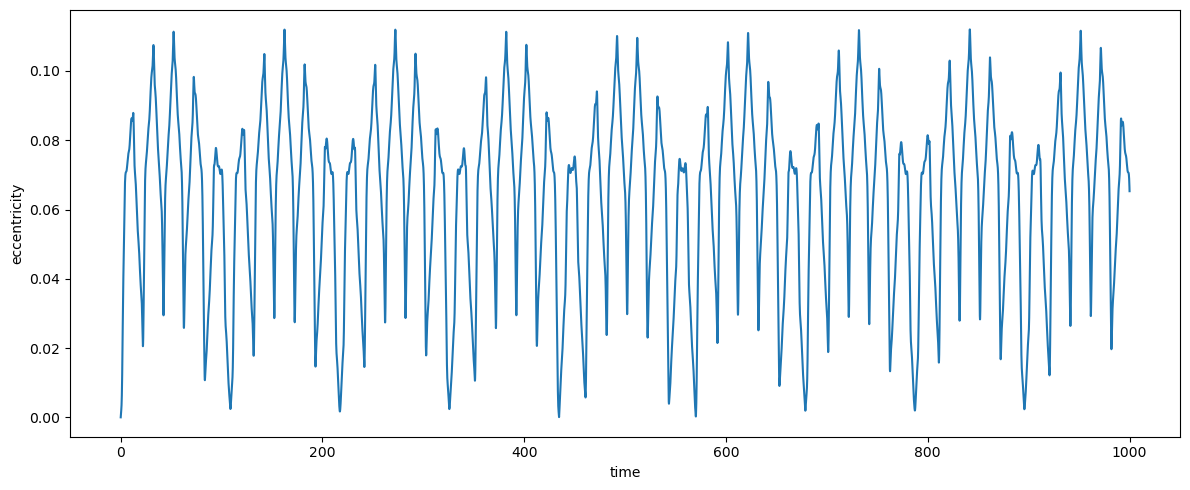

Max Eccentricity : 0.1119759912375165


In [17]:
### (ii) ###
### 3body.py, modified ###

import numpy as np
import matplotlib.pyplot as plt
import sys ###

def initialize(n, v0, eps2, mj, rj):
    mass = np.ones(n)/n
    if n == 2:
        pos = np.array([[1.0,0,0],[-1.0,0,0]])
        vel = np.array([[0,v0,0],[0,-v0,0]])
    else:
        # Simple planetary system.
        ms = 1.0
        me = 3.e-6
        re = 1.0
        mass = np.array([ms, me, mj])
        pos = np.array([[0.,0.,0.], [re,0.,0.], [0.,rj,0.]])
        vel = np.array([[0.,0.,0.],
                        [0.,np.sqrt((ms+me)*re/(re**2+eps2)),0.],
                        [-np.sqrt((ms+mj)*rj/(rj**2+eps2)),0.,0.]])

    # Move to the center of mass frame.
    
    m = mass.reshape(n,1)/mass.sum() # mi/mtot
    pos -= (m*pos).sum(axis=0) # xij - sum_i(xij*mi/mtot)
    vel -= (m*vel).sum(axis=0)

    return mass, pos, vel

def potential_energy(mass, pos, eps2):
    pot = 0.0
    for i in range(len(mass)):
        r = pos[i+1:] - pos[i]
        r2 = (r**2).sum(axis=1) + eps2 #axis = 1 sums over columns (dimensions), result of size rows (bodies) j>i
        pot -= mass[i]*(mass[i+1:]/np.sqrt(r2)).sum() #piecewise division due to numpy broadcasting, sum over bodies j>i
    return pot

def kinetic_energy(mass, vel):
    return 0.5*(mass*(vel**2).sum(axis=1)).sum() #sum over dimensions first, then bodies

def energy(mass, pos, vel, eps2):
    T = kinetic_energy(mass, vel)
    U = potential_energy(mass, pos, eps2)
    return T+U

def output(t, E0, mass, pos, vel, eps2):
    E = energy(mass, pos, vel, eps2)
    print('t =', t, 'dE =', E-E0)

def acceleration(mass, pos, eps2):
    n = len(mass)
    acc = np.zeros((n,3)) # acc modified in place
    for i in range(n):
        r = pos - pos[i,:] #del x,y,z to all other bodies, including itself
        r2  = (r**2).sum(axis=1) + eps2 #summing over dimensions, size of bodies
        acc[i] = (r*(mass/(np.power(r2,1.5))).reshape(n,1)).sum(axis=0) #reshape to multiply with corresponding body pair, sum over body pairs
    return acc

def step(t, mass, pos, vel, eps2, dt):

    # Second-order predictor-corrector.

    acc = acceleration(mass, pos, eps2)
    pos += dt*(vel+0.5*dt*acc)
    anew = acceleration(mass, pos, eps2)
    vel += 0.5*dt*(acc+anew)

    return t+dt,pos,vel

def kdk_step(t, mass, pos, vel, eps2, dt):
    vel += 0.5*acceleration(mass, pos, eps2)*dt
    pos += vel*dt
    vel += 0.5*acceleration(mass, pos, eps2)*dt
    t += dt
    return t, pos, vel

def orbital_elements(m1, m2, x1, x2, v1, v2, eps2):
    M = m1+m2
    x = x2-x1
    v = v2-v1
    r2 = (x**2).sum() + eps2
    v2 = (v**2).sum()
    E = 0.5*v2 - M/np.sqrt(r2)
    a = -0.5*M/E
    h2 = ((np.cross(x,v))**2).sum()
    ecc = (1 + 2*E*h2/M**2)**0.5
    return a, ecc, E, h2**0.5
    
def main(N, seed, eps, dt, t_end, dt_dia, v0, mj, rj):
    # Initial conditions.

    t = 0.0
    mass, pos, vel = initialize(N, v0, eps**2, mj, rj)

    # Initial diagnostics.
    
    E0 = energy(mass, pos, vel, eps**2)
    print('Initial E =', E0)
    output(t, E0, mass, pos, vel, eps**2)
    a,e,Erel,h = orbital_elements(mass[0], mass[1], pos[0], pos[1],
                                  vel[0], vel[1], eps**2)
    print('semimajor axis =', a, ' eccentricity =', e)

    # Run forward to specified time.

    tplot = []
    dEplot = []
    hplot = []
    aplot = []
    eccplot = []

    t_dia = dt_dia

    while t < t_end-0.5*dt:
        t,pos,vel = step(t, mass, pos, vel, eps**2, dt)
        
        E = energy(mass, pos, vel, eps**2)
        a, e, Erel, h = orbital_elements(mass[0], mass[1], pos[0],
                                      pos[1], vel[0], vel[1], eps**2)
        if t >= t_dia-0.5*dt:
            t_dia += dt_dia
            output(t, E0, mass, pos, vel, eps**2)
            if a <= 0.0:
                print('escaped')
                break

        tplot.append(t)
        dEplot.append(E-E0)
        hplot.append(h)
        aplot.append(a)
        eccplot.append(e)

    # Final diagnostics.
    
    output(t, E0, mass, pos, vel, eps**2)

    plt.figure(figsize=(12,5))

    # dont need to plot semimajor    
    #plt.subplot(2,1,1)
    #plt.plot(tplot, aplot)
    #plt.xlabel('time')
    #plt.ylabel('semimajor axis')

    #plt.subplot(2,1,2)
    plt.plot(tplot, eccplot)
    plt.xlabel('time')
    plt.ylabel('eccentricity')

    plt.tight_layout()
    plt.show()

    print(f"Max Eccentricity : {np.max(eccplot)}")

def new_option_parser():
    from optparse import OptionParser
    result = OptionParser()
    result.add_option("-n", 
                      dest="N", type="int", default ="3",
                      help="number of particles [%default]")
    result.add_option("-s", 
                      dest="seed", type="int", default ="42",
                      help="random seed [%default]")
    result.add_option("-e", 
                      dest="eps", type="float", default ="1e-6",
                      help="softening length eps [%default]") # Set to ~0 
    result.add_option("-d", 
                      dest="dt", type="float", default ="0.01",
                      help="time step [%default]")
    result.add_option("-D", 
                      dest="dt_dia", type="float", default ="10.0",
                      help="diagnostic time step [%default]")
    result.add_option("-M", 
                      dest="mj", type="float", default ="0.03",
                      help="Jupiter mass [%default]") # Set to 0.03
    result.add_option("-R", 
                      dest="rj", type="float", default ="2.0",
                      help="Jupiter semimajor axis [%default]") # Set to 2.0
    result.add_option("-t", 
                      dest="t_end", type="float", default ="1000.0",
                      help="integration interval [%default]") # Set to 1000
    result.add_option("-v", 
                      dest="v0", type="float", default ="0.25",
                      help="initial 2-body v [%default]")
    return result

if __name__ in ('__main__'):
    sys.argv = sys.argv[:1] # Allows use with Jupyter notebook
    o, arguments  = new_option_parser().parse_args()
    import pprint
    pp = pprint.PrettyPrinter()
    print('Command-line parameters:')
    pp.pprint(o.__dict__)
    main(**o.__dict__)


### 1.(b)

Command-line parameters:
{'N': 3,
 'dt': 0.01,
 'dt_dia': 10.0,
 'eps': 1e-06,
 'mj': 0.03,
 'rj': 2.0,
 'seed': 42,
 't_end': 2000.0,
 'v0': 0.25}
Initial E = -0.004168185748392092
t = 0.0 dE = 0.0
semimajor axis = 0.9999999999999998  eccentricity = 1.0000444493033002e-06
t = 9.999999999999831 dE = -4.441221609224888e-11
t = 20.000000000000327 dE = -2.7133404030543762e-11
t = 30.00000000000189 dE = 1.1448860089136037e-11
t = 40.00000000000061 dE = 9.464005100434658e-12
t = 49.99999999999862 dE = -2.9951948907203096e-11
t = 59.99999999999663 dE = -4.402933660024866e-11
t = 69.9999999999989 dE = -1.0281804921352666e-11
t = 80.00000000000402 dE = 1.7441707800269768e-11
t = 90.00000000000914 dE = -4.9381887468058494e-12
t = 100.00000000001425 dE = -4.1849649613789897e-11
t = 110.00000000001937 dE = -3.4421047609423105e-11
t = 120.00000000002449 dE = 5.479066852998038e-12
t = 130.00000000002674 dE = 1.4278169792325546e-11
t = 140.00000000001765 dE = -2.2003891764210692e-11
t = 150.00000000

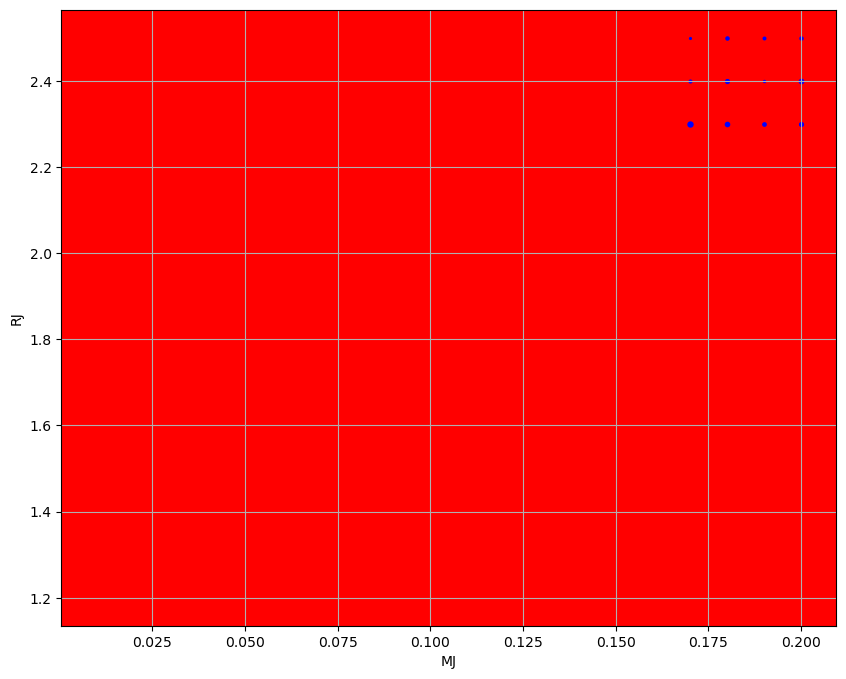

In [25]:
### (ii) ###
### 3body.py, modified ###

import numpy as np
import matplotlib.pyplot as plt
import sys ###

def initialize(n, v0, eps2, mj, rj):
    mass = np.ones(n)/n
    if n == 2:
        pos = np.array([[1.0,0,0],[-1.0,0,0]])
        vel = np.array([[0,v0,0],[0,-v0,0]])
    else:
        # Simple planetary system.
        ms = 1.0
        me = 3.e-6
        re = 1.0
        mass = np.array([ms, me, mj])
        pos = np.array([[0.,0.,0.], [re,0.,0.], [0.,rj,0.]])
        vel = np.array([[0.,0.,0.],
                        [0.,np.sqrt((ms+me)*re/(re**2+eps2)),0.],
                        [-np.sqrt((ms+mj)*rj/(rj**2+eps2)),0.,0.]])

    # Move to the center of mass frame.
    
    m = mass.reshape(n,1)/mass.sum() # mi/mtot
    pos -= (m*pos).sum(axis=0) # xij - sum_i(xij*mi/mtot)
    vel -= (m*vel).sum(axis=0)

    return mass, pos, vel

def potential_energy(mass, pos, eps2):
    pot = 0.0
    for i in range(len(mass)):
        r = pos[i+1:] - pos[i]
        r2 = (r**2).sum(axis=1) + eps2 #axis = 1 sums over columns (dimensions), result of size rows (bodies) j>i
        pot -= mass[i]*(mass[i+1:]/np.sqrt(r2)).sum() #piecewise division due to numpy broadcasting, sum over bodies j>i
    return pot

def kinetic_energy(mass, vel):
    return 0.5*(mass*(vel**2).sum(axis=1)).sum() #sum over dimensions first, then bodies

def energy(mass, pos, vel, eps2):
    T = kinetic_energy(mass, vel)
    U = potential_energy(mass, pos, eps2)
    return T+U

def output(t, E0, mass, pos, vel, eps2):
    E = energy(mass, pos, vel, eps2)
    print('t =', t, 'dE =', E-E0)

def acceleration(mass, pos, eps2):
    n = len(mass)
    acc = np.zeros((n,3)) # acc modified in place
    for i in range(n):
        r = pos - pos[i,:] #del x,y,z to all other bodies, including itself
        r2  = (r**2).sum(axis=1) + eps2 #summing over dimensions, size of bodies
        acc[i] = (r*(mass/(np.power(r2,1.5))).reshape(n,1)).sum(axis=0) #reshape to multiply with corresponding body pair, sum over body pairs
    return acc

def step(t, mass, pos, vel, eps2, dt):

    # Second-order predictor-corrector.

    acc = acceleration(mass, pos, eps2)
    pos += dt*(vel+0.5*dt*acc)
    anew = acceleration(mass, pos, eps2)
    vel += 0.5*dt*(acc+anew)

    return t+dt,pos,vel

def kdk_step(t, mass, pos, vel, eps2, dt):
    vel += 0.5*acceleration(mass, pos, eps2)*dt
    pos += vel*dt
    vel += 0.5*acceleration(mass, pos, eps2)*dt
    t += dt
    return t, pos, vel

def orbital_elements(m1, m2, x1, x2, v1, v2, eps2):
    M = m1+m2
    x = x2-x1
    v = v2-v1
    r2 = (x**2).sum() + eps2
    v2 = (v**2).sum()
    E = 0.5*v2 - M/np.sqrt(r2)
    a = -0.5*M/E
    h2 = ((np.cross(x,v))**2).sum()
    ecc = (1 + 2*E*h2/M**2)**0.5
    return a, ecc, E, h2**0.5
    
def main(N, seed, eps, dt, t_end, dt_dia, v0, mj, rj):
    # Initial conditions.

    t = 0.0
    mass, pos, vel = initialize(N, v0, eps**2, mj, rj)

    # Initial diagnostics.
    
    E0 = energy(mass, pos, vel, eps**2)
    print('Initial E =', E0)
    output(t, E0, mass, pos, vel, eps**2)
    a,e,Erel,h = orbital_elements(mass[0], mass[1], pos[0], pos[1],
                                  vel[0], vel[1], eps**2)
    print('semimajor axis =', a, ' eccentricity =', e)

    # Run forward to specified time.

    tplot = []
    dEplot = []
    hplot = []
    aplot = []
    eccplot = []

    t_dia = dt_dia

    while t < t_end-0.5*dt:
        t,pos,vel = step(t, mass, pos, vel, eps**2, dt)
        
        E = energy(mass, pos, vel, eps**2)
        a, e, Erel, h = orbital_elements(mass[0], mass[1], pos[0],
                                      pos[1], vel[0], vel[1], eps**2)
        if t >= t_dia-0.5*dt:
            t_dia += dt_dia
            output(t, E0, mass, pos, vel, eps**2)
            if a <= 0.0:
                print('escaped')
                break

        tplot.append(t)
        dEplot.append(E-E0)
        hplot.append(h)
        aplot.append(a)
        eccplot.append(e)

    # Final diagnostics.
    
    output(t, E0, mass, pos, vel, eps**2)

    #plt.figure(figsize=(12,5))

    # dont need these plots
    #plt.subplot(2,1,1)
    #plt.plot(tplot, aplot)
    #plt.xlabel('time')
    #plt.ylabel('semimajor axis')

    #plt.subplot(2,1,2)
    #plt.plot(tplot, eccplot)
    #plt.xlabel('time')
    #plt.ylabel('eccentricity')


    #plt.tight_layout()
    #plt.show()

    #print(f"Max Eccentricity : {np.max(eccplot)}")
    
    return e

def new_option_parser():
    from optparse import OptionParser
    result = OptionParser()
    result.add_option("-n", 
                      dest="N", type="int", default ="3",
                      help="number of particles [%default]")
    result.add_option("-s", 
                      dest="seed", type="int", default ="42",
                      help="random seed [%default]")
    result.add_option("-e", 
                      dest="eps", type="float", default ="1e-6",
                      help="softening length eps [%default]") # Set to ~0 
    result.add_option("-d", 
                      dest="dt", type="float", default ="0.01",
                      help="time step [%default]")
    result.add_option("-D", 
                      dest="dt_dia", type="float", default ="10.0",
                      help="diagnostic time step [%default]")
    result.add_option("-M", 
                      dest="mj", type="float", default ="0.03",
                      help="Jupiter mass [%default]") # Will be overriden
    result.add_option("-R", 
                      dest="rj", type="float", default ="2.0",
                      help="Jupiter semimajor axis [%default]") # Will be overriden
    result.add_option("-t", 
                      dest="t_end", type="float", default ="2000.0",
                      help="integration interval [%default]") # Set to 2000
    result.add_option("-v", 
                      dest="v0", type="float", default ="0.25",
                      help="initial 2-body v [%default]")
    return result

if __name__ in ('__main__'):
    sys.argv = sys.argv[:1] # Allows use with Jupyter notebook
    o, arguments  = new_option_parser().parse_args()
    stepsMJ = int((0.2 - 0.01) / 0.01 + 1)
    stepsRJ = int((2.5 - 1.2) / 0.1 + 1)
    MJList = np.linspace(0.01, 0.20, stepsMJ)
    RJList = np.linspace(1.2, 2.5, stepsRJ)
    import pprint
    pp = pprint.PrettyPrinter()
    print('Command-line parameters:')
    pp.pprint(o.__dict__)
    params = dict(o.__dict__)
    plt.figure(figsize=(10,8))
    for i in range(len(MJList)):
        for j in range(len(RJList)):
            params["mj"] = MJList[i]
            params["rj"] = RJList[j]
            ecc = main(**params)
            if ecc > 0.5:
                ecolor = "red"
            else:
                ecolor = "blue"
            plt.scatter(MJList[i], RJList[j], color=ecolor, s=ecc*40)

    plt.grid(True)
    plt.xlabel("MJ")
    plt.ylabel("RJ")
    plt.show()

